# Extraction of Kos Angle from Event Data
This Jupyter notebook can serve as an exploration the data processing taken place in the scientific paper titled:
The Kos Angle, an optimizing parameter for football expected goals (xG).


Open event data that's provided by Statsbomb typically contains structured information about various ball events or actions that occur during a football match. Here's a brief overview of the type of data usually included:

-  **Event type:** such as passes, shots, tackles, fouls, interceptions, and more.

-  **Location coordinates:** Coordinates or positional data related to where the event occurred/ended up using X and Y coordinates.

-  **Timestamps** Timing information, including when each event occurred during the match.

-  **Match and team information:** Details about the match, teams involved, and additional metadata.

-  **Outcome and result:** Outcome of events, such as goals scored, successful passes, or unsuccessful tackles.

For the main purpose of jupyter notebook, its mandatory to know that we're mainly going to operate on shot freeze frames that are attached to every shot revealing the location of all players, attacking or defending, within the camera frame, as well as the goalkeeper's position.

In [1]:
import json 
import math 
import numpy as np 
import pandas as pd 
import geopandas as gpd 

from mplsoccer import Pitch
from shapely.geometry import MultiPoint, Polygon, Point 

import matplotlib.pyplot as plt
import os

from mplsoccer import VerticalPitch, FontManager, Sbopen, add_image

plt.style.use('ggplot')

## *1. Loading and visualizing short_freeze_frames*

In [2]:
with open('data/events/2275078.json') as file:
    data= json.load(file)

shots_list= []
for item in data:
    shot = item.get('shot')
    location = item.get('location')
    id_ = item.get('id')
    if shot and 'freeze_frame' in shot:
        shots_list.append((id_, shot['freeze_frame'], location ))
        
shots_df= pd.DataFrame(data= shots_list, columns= ['id', 'freeze_frame', 'location'])

In [3]:
# extracting location cordinates
shots_df[['X','Y']] = shots_df['location'].apply(lambda x: pd.Series(x, index=['X', 'Y']))
shots_df.head()

,id,freeze_frame,location,X,Y
0,f95044e8-8ac7-4e66-b7f3-0dc64a9874c8,"[{'location': [80.8, 40.3], 'player': {'id': 1...","[97.0, 54.9]",97.0,54.9
1,6d3e375f-f99f-4a2e-ba4c-07b56778d5ea,"[{'location': [86.8, 15.7], 'player': {'id': 1...","[93.2, 42.4]",93.2,42.4
2,cf44704a-eda2-4e2f-9d92-898ba569a0ce,"[{'location': [95.1, 40.5], 'player': {'id': 1...","[103.3, 24.8]",103.3,24.8
3,5ebb4457-9b5e-47fc-bc0b-a2f8c281d1c1,"[{'location': [110.5, 49.3], 'player': {'id': ...","[107.2, 51.5]",107.2,51.5
4,2cefce5b-ff75-471a-8807-385b2e1a795d,"[{'location': [104.8, 52.7], 'player': {'id': ...","[101.6, 48.7]",101.6,48.7


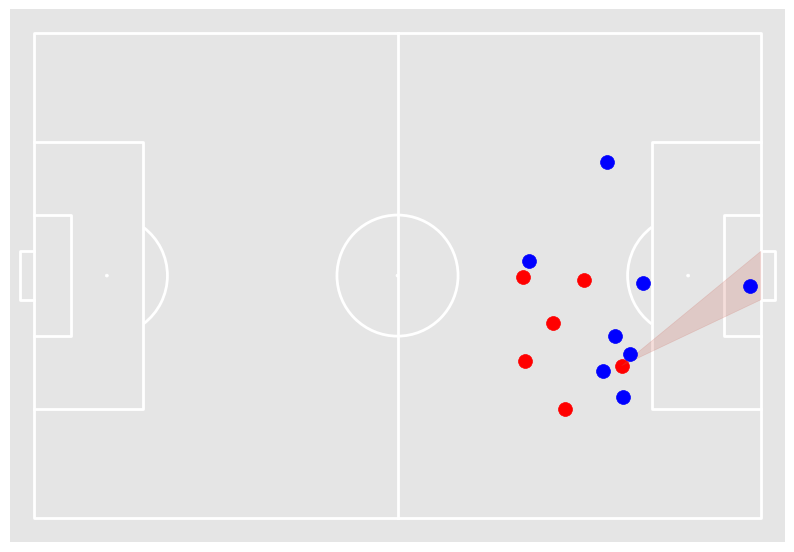

In [4]:
# Data
freeze_frame_data = shots_df['freeze_frame'].iloc[0]
# Setup the pitch
pitch = Pitch( goal_type='box')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 7))
pitch.draw(ax=ax)

# plot the angle to the goal ans shot taker
pitch.goal_angle(shots_df['X'][0], shots_df['Y'][0], ax=ax, alpha=0.2, zorder=1.1,
                 color='#cb5a4c', goal='right')

ax.scatter(shots_df['X'][0], shots_df['Y'][0], color='red', s=100, zorder=1)

#plot players
for player_data in freeze_frame_data:
    x, y = player_data['location']
    if player_data['teammate']:
        color = 'red'
    else:
        color = 'blue'
    ax.scatter(x, y, color=color, s=100, zorder=3)
plt.show()


That's exactly how players where positioning themeselves when a shot was taken!

## *2. Identifying players who interfers with the shot angle*

We construct shot angle polygons using player and goal post coordinates, then assesses player interference by checking for intersections with these polygons, resulting in a boolean value indicating interference status.

In [5]:
events_id= list(shots_df.id)
shot_frames= list(shots_df['freeze_frame'])

rows=[]
for event_id, frame in zip(events_id, shot_frames):
    for player in frame:
        rows.append((event_id, player['location'][0], player['location'][1],
                     player['position']['name'],player['teammate']))
df_shot_frame= pd.DataFrame(data= rows, columns=["id", "x", "y", "position", "teammate"])

statsbomb_pitch = Pitch()
vertices = np.zeros((len(df_shot_frame), 3, 2))
vertices[:, 1:, :] = statsbomb_pitch.goal_right
vertices[:, 0, :] = df_shot_frame[['x','y']].values
vertices = gpd.GeoSeries([Polygon(vert) for vert in vertices])
vertices = gpd.GeoDataFrame({'id': df_shot_frame['id'], 'shot_polygon': gpd.GeoSeries(vertices)})

player_positions = gpd.GeoSeries.from_xy(df_shot_frame['x'], df_shot_frame['y'])
player_positions = gpd.GeoDataFrame({'id': df_shot_frame['id'], 'position': player_positions,
                                    'Tactical position':df_shot_frame["position"], 'teammate':df_shot_frame["teammate"],
                                     'X_':df_shot_frame["x"], 'Y_':df_shot_frame["y"]
                                    })

player_positions = gpd.GeoDataFrame(player_positions.merge(vertices, on='id'))

#detect wether players intersects with the shot angle
player_positions['does player interfer with the goal angle?'] = player_positions['position'].intersects(player_positions['shot_polygon'])

#drop players who doesn't interefer with the shot angle
player_positions= player_positions[player_positions['does player interfer with the goal angle?']]
player_positions.head()

,id,position,Tactical position,teammate,X_,Y_,shot_polygon,does player interfer with the goal angle?
0,f95044e8-8ac7-4e66-b7f3-0dc64a9874c8,POINT (80.80000 40.30000),Left Defensive Midfield,True,80.8,40.3,"POLYGON ((80.80000 40.30000, 120.00000 44.0000...",True
14,f95044e8-8ac7-4e66-b7f3-0dc64a9874c8,POINT (85.70000 47.80000),Center Attacking Midfield,True,85.7,47.8,"POLYGON ((85.70000 47.80000, 120.00000 44.0000...",True
28,f95044e8-8ac7-4e66-b7f3-0dc64a9874c8,POINT (87.60000 62.00000),Left Wing,True,87.6,62.0,"POLYGON ((87.60000 62.00000, 120.00000 44.0000...",True
39,f95044e8-8ac7-4e66-b7f3-0dc64a9874c8,POINT (90.80000 40.70000),Right Wing,True,90.8,40.7,"POLYGON ((80.80000 40.30000, 120.00000 44.0000...",True
42,f95044e8-8ac7-4e66-b7f3-0dc64a9874c8,POINT (90.80000 40.70000),Right Wing,True,90.8,40.7,"POLYGON ((90.80000 40.70000, 120.00000 44.0000...",True


## *3. Angles calculation: Kos angle, shot angle, and angles occupied by players (bar shooter)*

$$\alpha = \arccos\left(\frac{{2 \times (x - LP)^2 + (y - y_b)^2 + (y - y_c)^2 - (y_b - y_c)^2}}{{2 \times \sqrt{{((x - LP)^2 + (y - y_b)^2) \times ((x - LP)^2 + (y - y_c)^2)}}}}\right)$$


$$\theta = \arccos\left(\frac{(x - x_i)^2 + (y - y_i)^2 - \left(\frac{L_i}{2}\right)^2}{\sqrt{((x - x_i)^2 + (y - y_i - (L_i/2))^2) \times ((x - x_i)^2 + (y - y_i + (L_i/2))^2)}}\right)$$


In [6]:
xb, yb = (120, 44)
xc, yc = (120, 36)
LP = 120

def calculate_shot_angle(x, y):
    numerator = 2 * (x - LP) ** 2 + (y - yb) ** 2 + (y - yc) ** 2 - (yb - yc) ** 2
    denominator = 2 * math.sqrt(((x - LP) ** 2 + (y - yb) ** 2) * ((x - LP) ** 2 + (y - yc) ** 2))
    shot_angle_radians = math.acos(numerator / denominator)
    angle = math.degrees(shot_angle_radians)
    return angle

def calculate_angle(xy, xi_yi_Li):
    x, y = xy
    xi, yi, Li = xi_yi_Li
    numerator = (x - xi) ** 2 + (y - yi) ** 2 - (Li / 2) ** 2
    denominator1 = (x - xi) ** 2 + (y - yi - (Li / 2)) ** 2
    denominator2 = (x - xi) ** 2 + (y - yi + (Li / 2)) ** 2
    try:
        angle_radians = math.acos(numerator / math.sqrt(denominator1 * denominator2))
        anlge = math.degrees(angle_radians)
    except ValueError:
        anlge = 0.0
    
    return anlge

def determine_L(row):
    if row['teammate']:
        return 0.4
    elif row['Tactical position'] == 'Goalkeeper':
        return 1.4
    else:
        return 0.5

In [7]:
#create a column for the width of player based on his position and wheter he's a teammate of the shooter or not
player_positions['L'] = player_positions.apply(determine_L, axis=1)

#add as much potential features as possible 
player_positions = gpd.GeoDataFrame(player_positions.merge(shots_df, on='id'))

In [8]:
def calculate_angle_for_row(row):
    xy = (row['X'], row['Y'])
    xi_yi_Li = (row['X_'], row['Y_'], row['L'])
    return calculate_angle(xy, xi_yi_Li)

#calculate the angle of each player
player_positions['angle'] = player_positions.apply(calculate_angle_for_row, axis=1)

In [9]:
columns_to_drop= ['position', 'Tactical position', 'teammate', 'shot_polygon', 
                  'does player interfer with the goal angle?', 'L', 'location' , 'X_' ,'Y_']
player_positions.drop(columns= columns_to_drop, inplace= True)

In [10]:
grouped_df = player_positions.groupby('id').agg({
    'freeze_frame': 'first',
    'X': 'first',  
    'Y': 'first',  
    'angle': 'sum'
}).reset_index()

In [11]:
grouped_df.head()

,id,freeze_frame,X,Y,angle
0,01fbb08b-aa95-4c91-b15a-f061f1b4e2c6,"[{'location': [89.8, 29.9], 'player': {'id': 1...",92.4,31.2,88.891930
1,0c8b1931-7ba7-450f-a49b-20050d11f91c,"[{'location': [113.2, 34.4], 'player': {'id': ...",113.8,46.1,246.543849
2,2687cdaf-a169-412a-a68b-1eedec7b2355,"[{'location': [108.0, 33.2], 'player': {'id': ...",117.4,46.1,167.540920
3,2cefce5b-ff75-471a-8807-385b2e1a795d,"[{'location': [104.8, 52.7], 'player': {'id': ...",101.6,48.7,62.602041
4,2e84359f-23dd-47ae-a99f-2792abdd68b7,"[{'location': [111.4, 41.1], 'player': {'id': ...",114.7,48.5,94.647851
